In [30]:
stock_ = 'NIFTY 50'
index = True

In [31]:
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

<h3> Train Non Corona Model </h3>

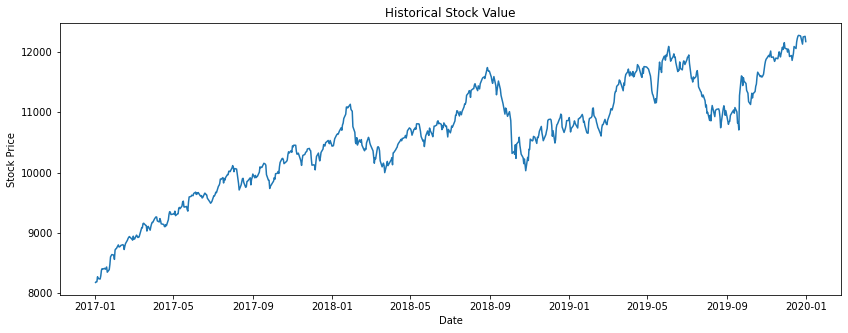

Epoch 1/15
17/17 [==============================] - 4s 238ms/step - loss: 0.0655 - val_loss: 0.0166
Epoch 2/15
17/17 [==============================] - 2s 147ms/step - loss: 0.0209 - val_loss: 0.0196
Epoch 3/15
17/17 [==============================] - 2s 142ms/step - loss: 0.0186 - val_loss: 0.0088
Epoch 4/15
17/17 [==============================] - 3s 149ms/step - loss: 0.0157 - val_loss: 0.0106
Epoch 5/15
17/17 [==============================] - 2s 141ms/step - loss: 0.0171 - val_loss: 0.0236
Epoch 6/15
17/17 [==============================] - 3s 149ms/step - loss: 0.0155 - val_loss: 0.0136
Epoch 7/15
17/17 [==============================] - 2s 146ms/step - loss: 0.0164 - val_loss: 0.0074
Epoch 8/15
17/17 [==============================] - 2s 141ms/step - loss: 0.0138 - val_loss: 0.0129
Epoch 9/15
17/17 [==============================] - 2s 141ms/step - loss: 0.0148 - val_loss: 0.0073
Epoch 10/15
17/17 [==============================] - 2s 142ms/step - loss: 0.0137 - val_loss: 0.0102

In [32]:
start = dt.datetime(2017,1,1)
end = dt.datetime(2019,12,31)
stk_data = gh(symbol=stock_,start=start,end=end, index=index)
plt.figure(figsize=(14,5))
plt.plot(stk_data['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data2['Date'] = stk_data['Date']
data2['Open'] = stk_data['Open']
data2['High'] = stk_data['High']
data2['Low'] = stk_data['Low']
data2['Close'] = stk_data['Close']
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 739):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
regressor = Sequential()
regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.5))
regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.5))
regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.5))
regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.5))
regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.5))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 15, batch_size = 32, validation_split=0.2)

<br>
<h2> Loading Saved Model </h2>

In [33]:
#try:
#    regressor = keras.models.load_model('saved_models/{}_pre'.format(stock_))
#except:
#    print('No saved model found, try after saving a model')

<br>
<h2> Testing Validity of Non Corona Training </h2>

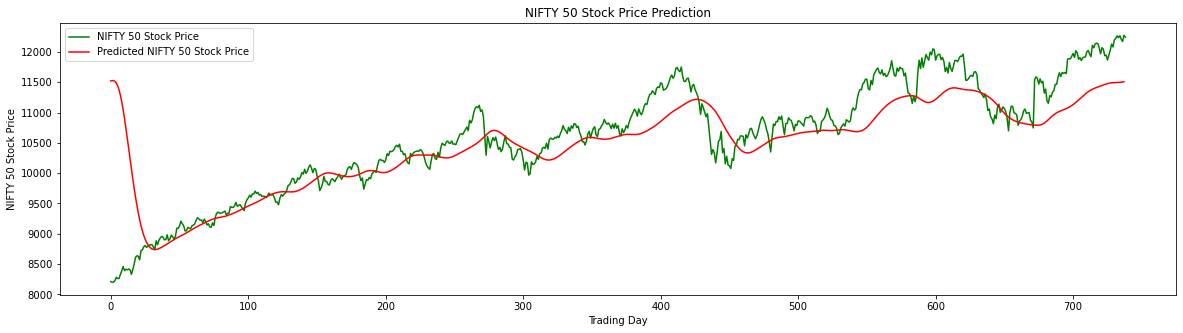

In [34]:
testdataframe= gh(symbol=stock_,start=dt.datetime(2017,1,1),end=dt.datetime(2019,12,31), index=index)
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 798):  
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
plt.figure(figsize=(20,5))
plt.plot(real_stock_price, color = 'green', label = '{} Stock Price'.format(stock_))
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted {} Stock Price'.format(stock_))
plt.title('{} Stock Price Prediction'.format(stock_))
plt.xlabel('Trading Day')
plt.ylabel('{} Stock Price'.format(stock_))
plt.legend()
plt.show()

<br>
<h2> Non Corona Trained in Corona Stage </h2>

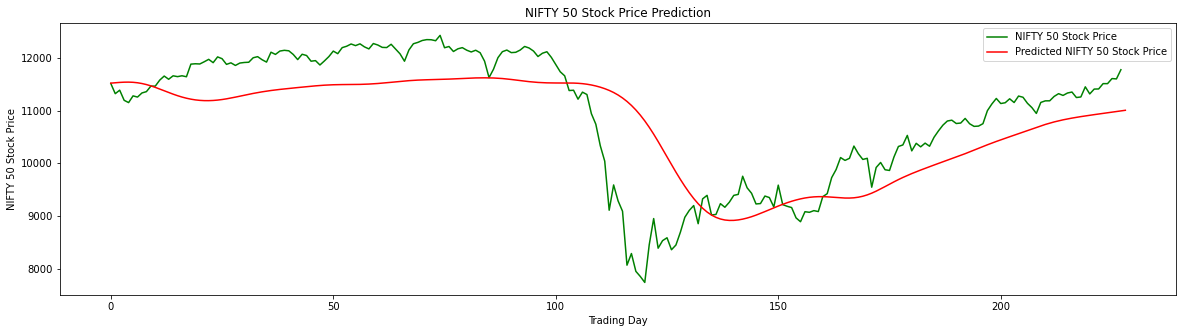

In [35]:
testdataframe= gh(symbol=stock_,start=dt.datetime(2019,10,1),end=dt.datetime(2020,8,31), index=index)
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 289): 
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
plt.figure(figsize=(20,5))
plt.plot(real_stock_price, color = 'green', label = '{} Stock Price'.format(stock_))
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted {} Stock Price'.format(stock_))
plt.title('{} Stock Price Prediction'.format(stock_))
plt.xlabel('Trading Day')
plt.ylabel('{} Stock Price'.format(stock_))
plt.legend()
plt.show()

<h2> Train Corona Model </h2>

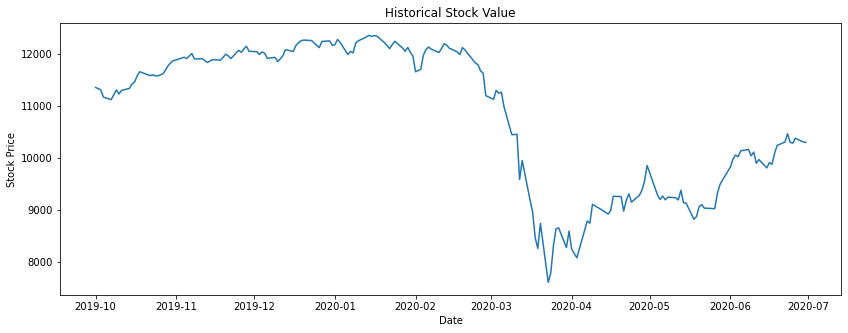

Epoch 1/15
4/4 [==============================] - 1s 255ms/step - loss: 0.2497 - val_loss: 0.0225
Epoch 2/15
4/4 [==============================] - 0s 44ms/step - loss: 0.0468 - val_loss: 0.0046
Epoch 3/15
4/4 [==============================] - 0s 44ms/step - loss: 0.0473 - val_loss: 0.0126
Epoch 4/15
4/4 [==============================] - 0s 42ms/step - loss: 0.0360 - val_loss: 0.0175
Epoch 5/15
4/4 [==============================] - 0s 49ms/step - loss: 0.0313 - val_loss: 0.0063
Epoch 6/15
4/4 [==============================] - 0s 67ms/step - loss: 0.0263 - val_loss: 0.0037
Epoch 7/15
4/4 [==============================] - 0s 44ms/step - loss: 0.0301 - val_loss: 0.0052
Epoch 8/15
4/4 [==============================] - 0s 47ms/step - loss: 0.0230 - val_loss: 0.0118
Epoch 9/15
4/4 [==============================] - 0s 58ms/step - loss: 0.0236 - val_loss: 0.0154
Epoch 10/15
4/4 [==============================] - 0s 47ms/step - loss: 0.0222 - val_loss: 0.0103
Epoch 11/15
4/4 [===========

In [36]:
start2 = dt.datetime(2019,10,1)
end2 = dt.datetime(2020,6,30)
stk_data2 = gh(symbol=stock_,start=start2,end=end2, index=index)
plt.figure(figsize=(14,5))
plt.plot(stk_data2['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()
stk_data2['Date'] = stk_data2.index
data3 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data3['Date'] = stk_data2['Date']
data3['Open'] = stk_data2['Open']
data3['High'] = stk_data2['High']
data3['Low'] = stk_data2['Low']
data3['Close'] = stk_data2['Close']
train_set2 = data3.iloc[:, 1:2].values
sc2 = MinMaxScaler(feature_range = (0, 1))
training_set_scaled2 = sc2.fit_transform(train_set2)
X_train2 = []
y_train2 = []
for i in range(60, 184):
    X_train2.append(training_set_scaled2[i-60:i, 0])
    y_train2.append(training_set_scaled2[i, 0]) 
X_train2, y_train2 = np.array(X_train2), np.array(y_train2)
X_train2 = np.reshape(X_train2, (X_train2.shape[0], X_train2.shape[1], 1))
regressor2 = Sequential()
regressor2.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train2.shape[1], 1)))
#regressor2.add(Dropout(0.2))
regressor2.add(LSTM(units = 60))
#regressor2.add(Dropout(0.2))
regressor2.add(Dense(units = 1))
regressor2.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor2.fit(X_train2, y_train2, epochs = 15, batch_size = 32, validation_split=0.2)

<h2> Corona Trained in Corona stage </h2>

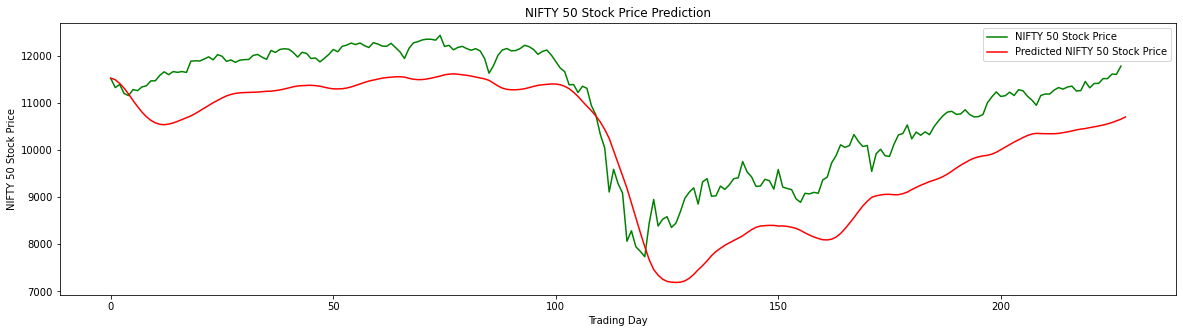

In [37]:
testdataframe2= gh(symbol=stock_,start=dt.datetime(2019,10,1),end=dt.datetime(2020,6,30), index=index)
testdataframe2['Date'] = testdataframe2.index
testdata2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata2['Date'] = testdataframe2['Date']
testdata2['Open'] = testdataframe2['Open']
testdata2['High'] = testdataframe2['High']
testdata2['Low'] = testdataframe2['Low']
testdata2['Close'] = testdataframe2['Close']
real_stock_price2 = testdata2.iloc[:, 1:2].values
dataset_total2 = pd.concat((data3['Open'], testdata2['Open']), axis = 0)
inputs2 = dataset_total2[len(dataset_total2) - len(testdata2) - 60:].values
inputs2 = inputs2.reshape(-1,1)
inputs2 = sc2.transform(inputs2)
X_test2 = []
for i in range(60, 289): 
    X_test2.append(inputs[i-60:i, 0])
X_test2 = np.array(X_test2)
X_test2 = np.reshape(X_test2, (X_test2.shape[0], X_test2.shape[1], 1))
predicted_stock_price2 = regressor2.predict(X_test2)
predicted_stock_price2 = sc2.inverse_transform(predicted_stock_price2)
plt.figure(figsize=(20,5))
predicted_stock_price2 += predicted_stock_price[0]-predicted_stock_price2[0]
plt.plot(real_stock_price, color = 'green', label = '{} Stock Price'.format(stock_))
plt.plot(predicted_stock_price2, color = 'red', label = 'Predicted {} Stock Price'.format(stock_))
plt.title('{} Stock Price Prediction'.format(stock_))
plt.xlabel('Trading Day')
plt.ylabel('{} Stock Price'.format(stock_))
plt.legend()
plt.show()

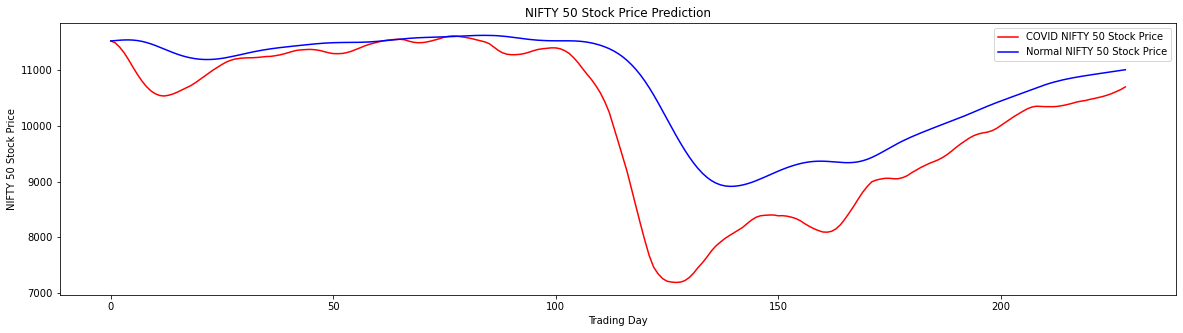

In [38]:
plt.figure(figsize=(20,5))
plt.plot(predicted_stock_price2, color = 'red', label = 'COVID {} Stock Price'.format(stock_))
plt.plot(predicted_stock_price, color = 'blue', label = 'Normal {} Stock Price'.format(stock_))
plt.title('{} Stock Price Prediction'.format(stock_))
plt.xlabel('Trading Day')
plt.ylabel('{} Stock Price'.format(stock_))
plt.legend()
plt.show()

<br>
<h2> Saving The Model </h2>

In [10]:
#regressor.save('saved_models/{}_pre'.format(stock_))